In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType ,FloatType
from pyspark.sql.types import StructType, StructField 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession \
    .builder \
    .appName("OlympicsProject") \
    .getOrCreate()

23/10/31 14:25:33 WARN Utils: Your hostname, SY001 resolves to a loopback address: 127.0.1.1; using 192.168.217.15 instead (on interface eth0)
23/10/31 14:25:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/31 14:25:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
# Creating a list of the schema in the format column_name, data_type of athlete events
labels = [
     ('ID',IntegerType()),
     ('Name',StringType()),
     ('Sex',StringType()),
     ('Age',IntegerType()),
     ('Height',IntegerType()),
     ('Weight',FloatType()),
     ('Team',StringType()),
     ('NOC',StringType()),
     ('Games',StringType()),
     ('Year',IntegerType()),
     ('Season',StringType()),
     ('City',StringType()),
     ('Sport',StringType()),
     ('Event',StringType()),
     ('Medal',StringType())
]

In [7]:
# Creating the schema that will be passed when reading the csv
schema = StructType([StructField (x[0], x[1], True) for x in labels])

In [8]:
#loading csv
df = spark.read.csv('athlete_events.csv', header=True, sep=",", schema=schema)

# Exploratory analysis of data

In [9]:
from pyspark.sql.functions import isnan, when, count, col

def missing_values_analysis(df):
    na_columns_ = [c for c in df.columns if df.where(df[c].isNull()).count() > 0]
    missing_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in na_columns_])
    ratio_ = df.select([((count(when(isnan(c) | col(c).isNull(), c))/df.count())*100).alias(c) for c in na_columns_])
    return missing_df, ratio_

def check_df(df):
    print("--------------------- Shape --------------------")
    print((df.count(), len(df.columns)))
    print("-------------------- Schema ---------------------")
    print(df.printSchema())
    print("----------------- NaN Analysis -----------------")
    missing_df, ratio_ = missing_values_analysis(df)
    print("Total Missing Values:")
    missing_df.show()
    print("Ratio:")
    ratio_.show()
    
check_df(df)

--------------------- Shape --------------------


(271116, 15)
-------------------- Schema ---------------------
root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: float (nullable = true)
 |-- Team: string (nullable = true)
 |-- NOC: string (nullable = true)
 |-- Games: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Season: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Medal: string (nullable = true)

None
----------------- NaN Analysis -----------------


Total Missing Values:
+----+------+------+
| Age|Height|Weight|
+----+------+------+
|9474| 60171| 62875|
+----+------+------+

Ratio:
+----------------+------------------+-----------------+
|             Age|            Height|           Weight|
+----------------+------------------+-----------------+
|3.49444518213606|22.193821095029435|23.19118015904631|
+----------------+------------------+-----------------+



In [10]:
df.limit(5)

ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1,A Dijiang,M,24,180,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's ...,NA
2,A Lamusi,M,23,170,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-...,NA
3,Gunnar Nielsen Aaby,M,24,NULL,NULL,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Fo...,NA
4,Edgar Lindenau Aabye,M,34,NULL,NULL,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's ...,Gold
5,Christine Jacoba ...,F,21,185,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Wom...,NA


# Evolution of femenine and masculine participation along the years for Summer Olympics

In [11]:
#Segregate summer and winter olympics on different dataframes 
summerOlympics = df.where(df.Season == 'Summer')
winterOlympics = df.where(df.Season == 'Winter')

In [12]:
#create temporary view of summer olympics to work with SQL API
summerOlympics.createOrReplaceTempView("summer_table")

In [13]:
#Male registers
query="""
        WITH unique_id AS (
            SELECT DISTINCT ID, Sex, Year
            FROM summer_table
            WHERE Sex == 'M'
        )
        SELECT year, COUNT(*) AS male_athletes
        FROM unique_id
        GROUP BY year
        ORDER BY year
        """
maleAthlethesPerYear= spark.sql(query)

In [14]:
maleAthlethesPerYear.limit(20)

year,male_athletes
1896,176
1900,1201
1904,644
1906,835
1908,1980
1912,2356
1920,2598
1924,3100
1928,2935
1932,1721


In [15]:
maleAthlethesPerYear_pd = maleAthlethesPerYear.toPandas() #convert to pandas dataframe

In [16]:
#Female registers
query="""
        WITH unique_id AS (
            SELECT DISTINCT ID, Sex, Year
            FROM summer_table
            WHERE Sex == 'F'
        )
        SELECT year, COUNT(*) AS female_athletes
        FROM unique_id
        GROUP BY year
        ORDER BY year
        """
femaleAthlethesPerYear= spark.sql(query)

In [17]:
femaleAthlethesPerYear.limit(20)

year,female_athletes
1900,23
1904,6
1906,6
1908,44
1912,53
1920,78
1924,156
1928,312
1932,201
1936,361


In [18]:
femaleAthlethesPerYear_pd = femaleAthlethesPerYear.toPandas() #convert to pandas dataframe

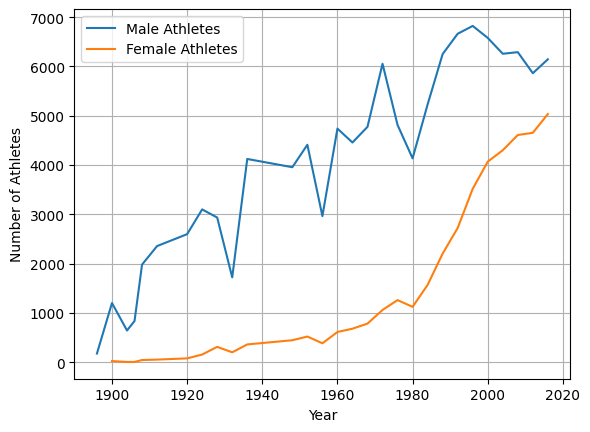

In [19]:
plt.plot(maleAthlethesPerYear_pd["year"], maleAthlethesPerYear_pd["male_athletes"], label='Male Athletes')
plt.plot(femaleAthlethesPerYear_pd["year"], femaleAthlethesPerYear_pd["female_athletes"], label='Female Athletes')
plt.xlabel("Year")
plt.ylabel("Number of Athletes")
plt.legend()
plt.grid()
plt.show()

# Top 3 countries with more medals

In [20]:
#create a new dataframe only with the registers of medal winner athletes 
summerMedals = summerOlympics.where(summerOlympics.Medal != "NA")

#create temporary view of summer olympics with medal winners athletes to work with SQL API
summerMedals.createOrReplaceTempView("medals_table")

In [21]:
#Count medals per country
query="""
        SELECT NOC, COUNT(*) AS totalNumberMedals
        FROM medals_table
        GROUP BY NOC
        ORDER BY totalNumberMedals DESC
        """
spark.sql(query).limit(3)

NOC,totalNumberMedals
USA,5002
URS,2063
GBR,1985


In [22]:
query= """
    SELECT NOC, Medal, COUNT(*) as MedalCount
    FROM medals_table
    WHERE NOC IN ('USA', 'URS', 'GBR')
    GROUP BY NOC, Medal;
    """
medalsPerCountry_pd=spark.sql(query).toPandas()

In [23]:
medalsPerCountry_pd

,NOC,Medal,MedalCount
0,URS,Gold,832
1,GBR,Silver,729
2,URS,Bronze,596
3,GBR,Bronze,620
4,GBR,Gold,636
5,USA,Silver,1333
6,URS,Silver,635
7,USA,Bronze,1197
8,USA,Gold,2472


In [24]:
# Filter dataframe for each country
us_medals = medalsPerCountry_pd[medalsPerCountry_pd['NOC'] == 'USA']
soviet_medals = medalsPerCountry_pd[medalsPerCountry_pd['NOC'] == 'URS']
uk_medals = medalsPerCountry_pd[medalsPerCountry_pd['NOC'] == 'GBR']

# Extract medal counts into lists
gold = [us_medals[us_medals['Medal'] == 'Gold']['MedalCount'].values[0],
        soviet_medals[soviet_medals['Medal'] == 'Gold']['MedalCount'].values[0],
        uk_medals[uk_medals['Medal'] == 'Gold']['MedalCount'].values[0]]

silver = [us_medals[us_medals['Medal'] == 'Silver']['MedalCount'].values[0],
          soviet_medals[soviet_medals['Medal'] == 'Silver']['MedalCount'].values[0],
          uk_medals[uk_medals['Medal'] == 'Silver']['MedalCount'].values[0]]

bronze = [us_medals[us_medals['Medal'] == 'Bronze']['MedalCount'].values[0],
          soviet_medals[soviet_medals['Medal'] == 'Bronze']['MedalCount'].values[0],
          uk_medals[uk_medals['Medal'] == 'Bronze']['MedalCount'].values[0]]

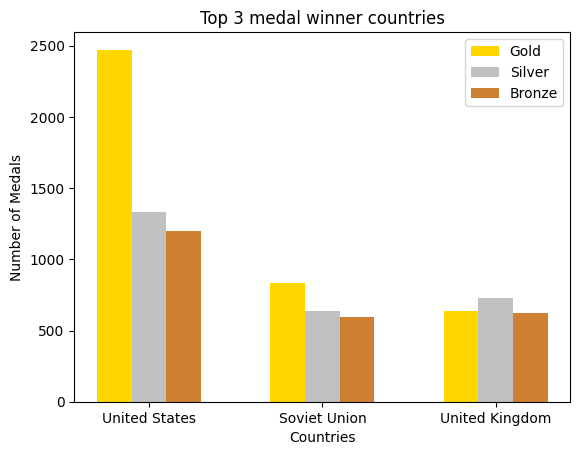

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 

X = ['United States','Soviet Union','United Kingdom'] 
goldMedals = gold 
silverMedals = silver
bronzeMedals = bronze

X_axis = np.arange(len(X)) 

plt.bar(X_axis - 0.2, goldMedals, 0.2, color ='gold', label = 'Gold') 
plt.bar(X_axis, silverMedals, 0.2, color ='silver', label = 'Silver') 
plt.bar(X_axis + 0.2, bronzeMedals, 0.2, color ='#cd7f32', label = 'Bronze') 

plt.xticks(X_axis, X) 
plt.xlabel("Countries") 
plt.ylabel("Number of Medals") 
plt.title("Top 3 medal winner countries") 
plt.legend() 
plt.show()

# Countries that haven't won a medal until 2020 games

In [26]:
query= """
    
    --Select all disctinct countries in the dataset
    WITH allCountries AS(
    SELECT DISTINCT NOC
    FROM summer_table
    ),
    
    --Select the disctinct winner medal countries in the dataset
    winnerCountries AS(
    SELECT DISTINCT NOC
    FROM medals_table
    )
    
    --Substarct the winner medal countries to the all countries dataset to obtain the non-winners
    SELECT allCountries.NOC 
    FROM allCountries
    LEFT JOIN winnerCountries
        ON allCountries.NOC = winnerCountries.NOC
    WHERE winnerCountries.NOC IS NULL;
    """

nonWinnersCountries = spark.sql(query)

In [27]:
nonWinnersCountries.count()

83

There are 83 countries that haven't won a medal until 2020 games

In [28]:
# Creating a list of the schema in the format column_name, data_type of noc_regions
labels_noc = [
     ('NOC',StringType()),
     ('region',StringType()),
     ('notes',StringType())
]

# Creating the schema that will be passed when reading the csv
schema_noc = StructType([StructField (x[0], x[1], True) for x in labels_noc])

In [29]:
#loading csv
nocRegions = spark.read.csv('noc_regions.csv', header=True, sep=",", schema=schema_noc)

In [30]:
#Join with the noc_regions column region to obtain the name of the countries
nwc_noc = nonWinnersCountries.join(nocRegions.select('NOC','region'), on='NOC', how='left')               

Lets take a look of 20 of those countries

In [31]:
nwc_noc.limit(20)

NOC,region
BUR,Burkina Faso
SOM,Somalia
IVB,"Virgin Islands, B..."
MAL,Malaysia
COD,Democratic Republ...
FSM,Micronesia
MYA,Myanmar
NEP,Nepal
BOL,Boliva
GEQ,Equatorial Guinea
